In [1]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import metrics
import os
import csv
from sklearn.cluster import MeanShift

In [2]:
from pylab import imshow
from pylab import plot

In [3]:
img = cv2.imread("Training/original_retinal_images/23_training.tif")
b,g,r = cv2.split(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)
img = cv2.merge([b,g,r])
cv2.imwrite('j.jpg',img)

True

In [40]:
def extract_bv(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)
    

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)
    f5 = Erosion(f5)
    f5 = Dilation(f5)
    
    _,fin = cv2.threshold(f5, 15, 255, cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(image.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)
    
    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    b_v = cv2.bitwise_not(finimage)
    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(b_v,1,255,cv2.THRESH_BINARY_INV)
    mask = np.ones(f6.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f6, f6, mask=mask)
    
    return im


In [5]:
def opening(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #开运算原理： 先腐蚀后膨胀，分离区域
    #闭运算原理： 先膨胀后腐蚀，消除孔洞
    return opening

In [6]:
def Erosion(img):
    kernel = np.ones((2,2),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    #腐蚀
    return erosion

In [7]:
def Erosion1(img):
    kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    #腐蚀
    return erosion

In [8]:
def Dilation(img):
    kernel = np.ones((1,1),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    #膨胀
    return dilation

In [9]:
def background(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,bg = cv2.threshold(img_gray, 20, 255, cv2.THRESH_BINARY)
    return bg

In [21]:
def score(result,order):
    check = Image.open("Training/blood_vessel_segmentation_masks/"+ order +"_manual1.gif")
    ck = check.convert('L')
    ck = np.array(ck)
    _,bnw1 = cv2.threshold(result, 20, 1, cv2.THRESH_BINARY)
    _,bnw2 = cv2.threshold(ck, 20, 1, cv2.THRESH_BINARY)
    bnw1 = bnw1.flatten()
    bnw2 = bnw2.flatten()
    acc = metrics.precision_score(bnw1, bnw2)
    rec = metrics.recall_score(bnw1, bnw2)
    
    return acc,rec

In [11]:
def bg_score(result,order):
    check = Image.open("Training/background_masks/"+ order +"_training_mask.gif")
    ck = check.convert('L')
    ck = np.array(ck)
    _,bnw1 = cv2.threshold(result, 20, 1, cv2.THRESH_BINARY)
    _,bnw2 = cv2.threshold(ck, 20, 1, cv2.THRESH_BINARY)
    bnw1 = bnw1.flatten()
    bnw2 = bnw2.flatten()
    acc = metrics.precision_score(bnw1, bnw2)
    rec = metrics.recall_score(bnw1, bnw2)
    
    return acc,rec

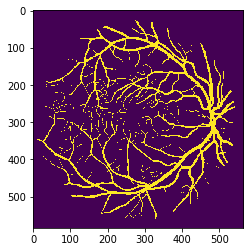

In [43]:
order = '24'
rst = Image.open("Training/blood_vessel_segmentation_masks/"+ order +"_manual1.gif")
rst = np.array(rst)
imshow(rst)

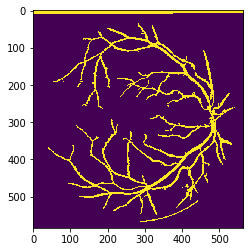

In [44]:
img = cv2.imread("Training/original_retinal_images/" + order + "_training.tif")
bv_img = extract_bv(img)

imshow(bv_img)
#cv2.imwrite('f.jpg',bv_img)

In [25]:
pre,rc = score(bv_img,order)
print("pre: "+str(pre)+" recall: "+str(rc))

pre: 0.7003719851205952 recall: 0.5367543375636074


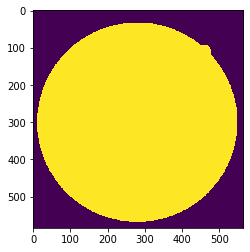

In [15]:
bg = background(img)
imshow(bg)

In [18]:
pre,rc = bg_score(bg,order)
print("pre: "+str(pre)+" recall: "+str(rc))

pre: 0.9906492729655791 recall: 1.0


In [13]:
mask = Image.open("Training/blood_vessel_segmentation_masks/"+ order +"_manual1.gif")
mask = mask.convert('L')
mask = np.array(mask)
d = np.hstack((bv_img,mask)) 
cv2.imwrite('rst21.jpg',d)

True

In [39]:
mask = Image.open("Training/background_masks/"+ order +"_training_mask.gif")
mask = mask.convert('L')
mask = np.array(mask)
d = np.hstack((bg,mask)) 
cv2.imwrite('rst21.jpg',d)

True

In [26]:
sp = 0
sr = 0
for order in range(21,41):
    zero = ''
    if order < 10:
        zero = '0'
    order = zero + str(order)
    img = cv2.imread("Training/original_retinal_images/" + order + "_training.tif")
    bv_img = extract_bv(img)
    pre,rc = score(bv_img,order)
    print(pre)
    sp += pre
    sr += rc
print('average precision: '+ str(sp/20) + '  average recall: ' + str(sr/20))

0.7251196366290859
0.6471535442316079
0.711688072549832
0.6907060085275576
0.4804067068742303
0.6683349653646683
0.68348639631273
0.6512349509743081
0.6639760729343087
0.4456420955030134
0.7464569303447582
0.7089386302994367
0.7092482949861351
0.6564561588255335
0.662833776038026
0.6336807490803701
0.6403384071287404
0.693085648066861
0.6760618033018202
0.7003719851205952
average precision: 0.6597610416546809  average recall: 0.5518839478256876


In [107]:
a=(sp/20)
b=(sr/20)
(a*b*2)/(a+b)

0.6010201526870139

In [196]:
    image = cv2.imread("Training/original_retinal_images/24_training.tif")
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)
    f5 = Erosion(f5)
    f5 = Dilation(f5)

    ret,fin = cv2.threshold(f5,15,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
    
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(image.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)
    
    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    
    cv2.imwrite('r.jpg',blood_vessels)

True